<h1>Ecommerce Analysis: Understanding Consumer Behaviour</h1>
Using checkout data of an e-commerce platform, let's try to understand which variables affect their decision in: <br>
        > making a purchase<br>
        > having a bigger basket amount<br>
Well explore the data, clean it, then model it. 

<h2>Exploratory Data Analysis: Cleaning & Enhancing</h2>
Let's understand and maximize our data. We have a dataset of a transactions, with unique user ID's and timestamps of the transaction. Seeing that user ID's are repeated, the primary key of this dataset is timestamp and user_id. Let's prove that, and let's explore the data.

In [1]:
#import module
import pandas as pd
import numpy as np

In [2]:
# prove that primary key is unique
data = pd.read_csv('insight-test.csv')
size = data.groupby(['user_id', 'time']).size()
size[size > 1]

Series([], dtype: int64)

We can safely conclude all rows is unique transaction data.

In [3]:
# print the head
data.head()

,user_id,is_new,time,voucher_type,voucher_valid,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,...,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
0,281605921,1,2015-06-12 03:41:44.263000+00:00,NaN,NaN,0.000029,0.0000,0.0,0.00,0.000000,...,2014-03-23 04:01:30+00:00,0,0.004158,0.001420,0.000000,0.000000,0.00000,0.000000,0.033242,0.155619
1,281605921,1,2015-06-15 04:11:26.177000+00:00,NaN,NaN,0.000024,0.0000,0.0,0.00,0.000000,...,2014-03-23 04:01:30+00:00,0,0.004158,0.001420,0.000000,0.000000,0.00000,0.000000,0.033242,0.155619
2,125302602,0,2015-04-24 14:07:48.720000+00:00,NaN,NaN,0.000164,0.0000,0.0,0.00,0.000000,...,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.00009,0.016166,0.033882,0.157703
3,125302602,0,2015-05-04 01:05:09.518000+00:00,1.0,1.0,0.000175,0.0002,1.0,0.01,0.019864,...,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.00009,0.016166,0.033882,0.157703
4,125302602,0,2015-05-15 11:18:25.739000+00:00,1.0,1.0,0.000170,0.0002,1.0,0.01,0.019324,...,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.00009,0.016166,0.033882,0.157703


<h3>Do we need to enhance the data?</h3>
Most columns of the dataset has been normalized and represented as numerical data. Even the categorical data has been coded, however we can still make the data cleaner, and perhaps lead us to better insights.

1. Let's maximize the use of dates.
2. Let's assign a code the marketing tiers to turn it into numerical data.
3. Find if there are any nulls.

In [4]:
# import module
import datetime as dt

In [5]:
# Calculating the age of the user at transaction, turning it into age by days
data['time'] = pd.to_datetime(data['time'])
data['account_created_at'] = pd.to_datetime(data['account_created_at'])
data['account_age_days'] = (data['time'] - data['account_created_at']).dt.days
# normalize data
data['account_age_days'] = (data['account_age_days'] - data['account_age_days'].min()) / (data['account_age_days'].max() - data['account_age_days'].min())

In [6]:
# Number coding categorical data
data['marketing_tier'] = data['marketing_tier'].astype('category').cat.codes

In [7]:
# Check Null / NaN
data.columns[data.isna().any()].tolist()

['voucher_type', 'voucher_valid']

To assume or guess what the values of these fields are can affect the accuracy of our analysis. Let's see if we replace the nulls, will the returned data make sense?

In [8]:
# replace nulls with 0s
data_filled = data
data_filled.fillna(0, inplace=True)
# find if our assumption is true
data_filled[(data_filled['voucher_valid'] ==  0) \
            & (data_filled['trx_is_voucher'] == 1) \
            & (data_filled['purchase'] == 1)].agg({'purchase':'count'})

purchase    194
dtype: int64

There are 194 purchases that are flagged as using a voucher, yet marked as voucher invalid. This does not make sense. Assuming that all vouchers must be valid before it can be applied, we will drop these fields.

In [9]:
# Drop columns with null values and check
data_cleaned = data
_ = data_cleaned.drop(['voucher_type', 'voucher_valid'], axis = 1, inplace = True)
data_cleaned.columns[data_cleaned.isna().any()].tolist()

[]

<h3>Do we need to format the dates?</h3>
Seeing that the transactions are timestamps, it would be great to see on which dates and on which days purchases happen more often. Let's break down the granularity.

In [10]:
# Find date range
print(data['time'].min())
print(data['time'].max())

2015-03-20 17:01:30.934000+00:00
2015-06-19 16:59:14.249000+00:00


Let's flag weekends and weekdays, and the name of the days, the age of the account and the time since the last transaction.

In [11]:
# get checkout date
data_cleaned['date_trx'] = data_cleaned['time'].dt.date
# get day
data_cleaned['day_trx'] = data_cleaned['time'].dt.weekday
# create a boolean for weekend
data_cleaned['weekend'] = data_cleaned['day_trx'] >= 5

In [12]:
# find days passed since last transaction
data_cleaned['date_trx_prev'] = data_cleaned.sort_values(['date_trx'], ascending = False) \
                       .groupby(['user_id'])['date_trx'].shift(-1)
data_cleaned['days_last_trx'] = data_cleaned['date_trx'] - data_cleaned['date_trx_prev']
data_cleaned['days_last_trx'] = data_cleaned['days_last_trx'].dt.days
# convert nulls into 0 values
data_cleaned['days_last_trx'].fillna(0, inplace = True)
# normalize it
data['days_last_trx'] = (data['days_last_trx'] - data['days_last_trx'].min()) / (data['days_last_trx'].max() - data['days_last_trx'].min())

In [13]:
# check 1 sample user_id to check outcome
data_cleaned[['user_id', 'date_trx', 'date_trx_prev', 'days_last_trx']].query('user_id == 125302602').sort_values('date_trx')

,user_id,date_trx,date_trx_prev,days_last_trx
12422,125302602,2015-04-16,NaN,0.000000
12420,125302602,2015-04-18,2015-04-16,0.022472
12421,125302602,2015-04-19,2015-04-18,0.011236
2,125302602,2015-04-24,2015-04-19,0.056180
8,125302602,2015-04-25,2015-04-24,0.011236
5,125302602,2015-04-26,2015-04-25,0.011236
6,125302602,2015-04-27,2015-04-26,0.011236
3,125302602,2015-05-04,2015-04-27,0.078652
7,125302602,2015-05-06,2015-05-04,0.022472
9,125302602,2015-05-07,2015-05-06,0.011236


From looking at the data dictionary, it can be concluded that all succesful purchases are either paid or remitted, and these values are just descriptors of how the purchase was completed. We will drop these fields. Without calculating we can know that most succesful purchases will be paid, and most of those will also be remitted. This barely does affect the decision making process of a consumer. Most consumers that want to purchase will purchase. This might lead to selection bias.<br><br>
Assuming all false is_paid and is_remitted fields are from system failures, we will drop these fields.

In [14]:
_ = data_cleaned.drop(['is_paid', 'is_remitted'], axis = 1, inplace = True)

<h2>Exploratory Data Analysis: Visualizations</h2>

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

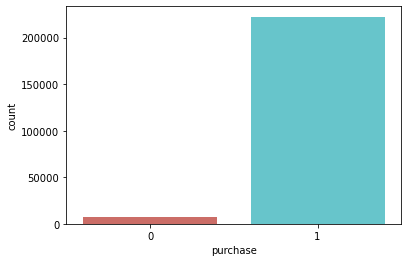

In [16]:
_ = sns.countplot(x = 'purchase', data = data_cleaned, palette = "hls")
#print(data_cleaned['purchase'].value_counts())
plt.show()

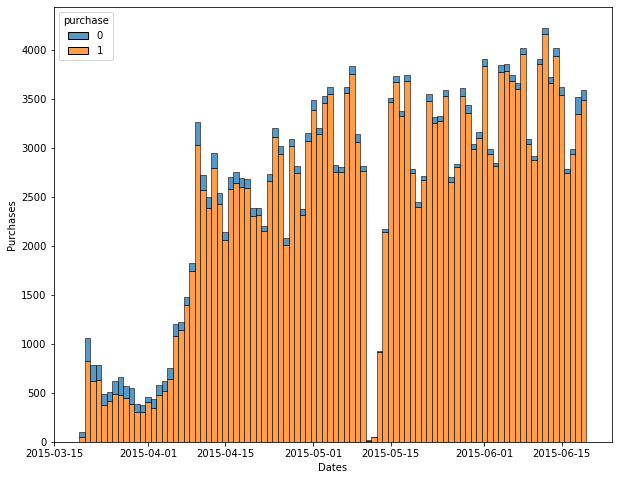

In [17]:
_ = plt.figure(figsize=(10, 8))
_ = plt.xlabel('Dates')
_ = plt.ylabel('Purchases')
_ = sns.histplot(x = 'date_trx' , hue = 'purchase', \
             multiple = 'stack',data = data_cleaned)
plt.show()

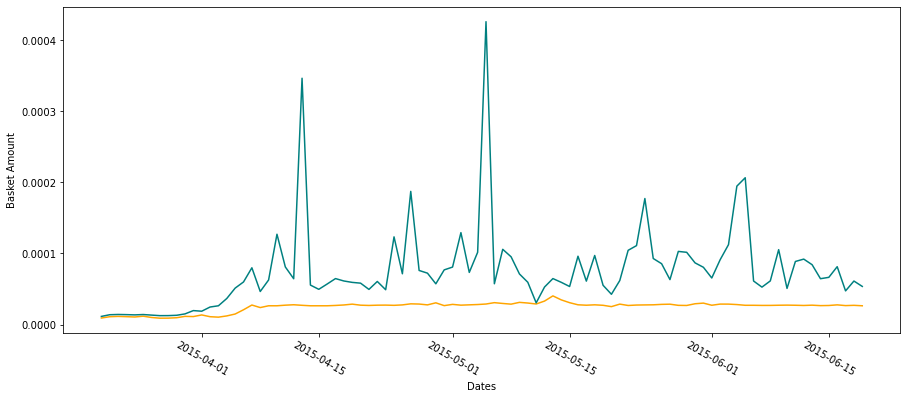

In [18]:
_ = plt.figure(figsize=(15, 6))
_ = plt.xlabel('Dates')
_ = plt.ylabel('Basket Amount')
_ = plt.xticks(rotation='-30')
_ = sns.lineplot(x = 'date_trx', y='basket_amount', \
                color='orange', data = data_cleaned, \
                ci = None, estimator = "median")
_ = sns.lineplot(x = 'date_trx', y='basket_amount', \
                color='teal', data = data_cleaned, \
                ci = None, estimator = "mean")
plt.show()

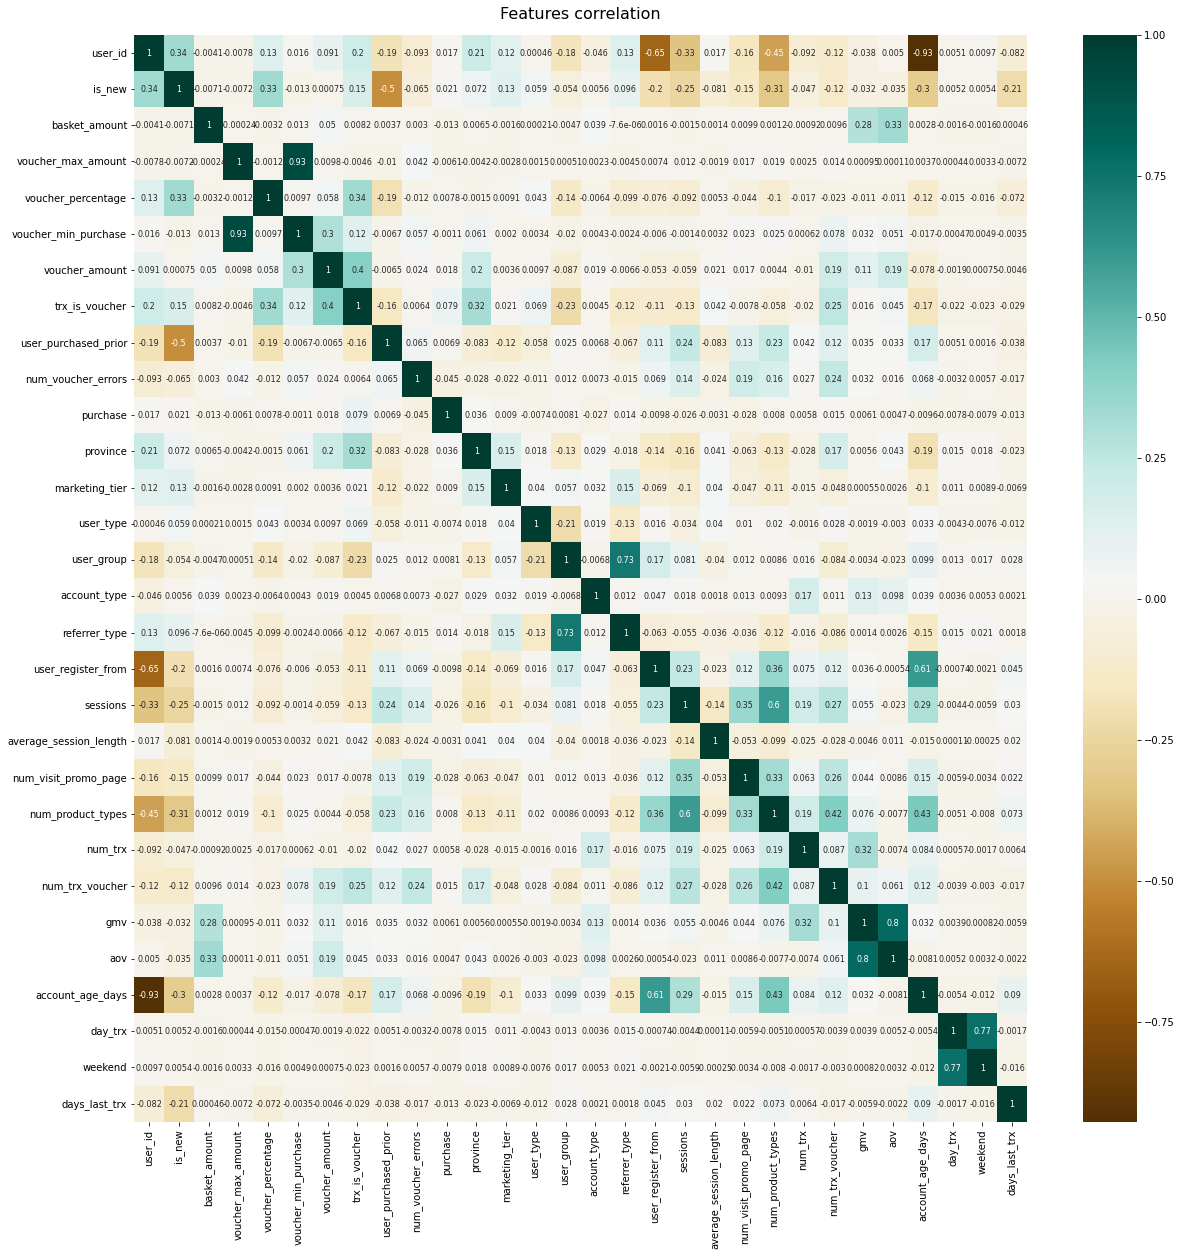

In [19]:
corr = data_cleaned.corr()
_ = plt.figure(figsize=(20, 20))
_ = sns.heatmap(corr, annot=True, cmap="BrBG", annot_kws={"fontsize":8})
_ = _.set_title('Features correlation', fontdict={'fontsize':16}, pad=16)

<h2>What did I realize from this analysis?</h2>
    > <i>There's an imbalance in data for purchases.</i> This can lead to our statistical models not learning the correct predictions and calculate which variables impact the decision of a purchase.<br>
    > The correlation that the dependent variable and the independent variable has is weak.<br>
We need to encode the data and remove unnecessary categorical flags.<br><br>

<h2>What model should I use?</h2>
For purchase, because this is a classification problem for a discrete variable, we'll be using <i>logistic regression</i>. For basket amount, because this is a continous variable, we'll be using <i>linear regression</i> (multivariate). We'll be using this because it's one of the simplest models. We'll look at the odds to see which top factors will affect the respective dependent variables.

<h2>Purchase: Data Encoding</h2>
Our current data might affect the result of our analysis, especially that we plan on using regression methods, categortical data might be misinterpreted by the model as hirarichal -- a data that just happens to so have a higher categorical "vaue" than the other might be mistaken as more important.

In [20]:
from sklearn.preprocessing import OneHotEncoder

# put categorical variables in a list 
categorical_vars = ['province', 'marketing_tier', 'user_type', 'user_group', 'account_type', 'referrer_type', 'day_trx']

# instantiate the one hot encoder
one_hot_encoder = OneHotEncoder(sparse=False, drop = "first")

In [21]:
# apply the one hot encoder logic 
encoder_vars_array = one_hot_encoder.fit_transform(data_cleaned[categorical_vars])

# create object for the feature names using the categorical variables
encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

# create a dataframe to hold the one hot encoded variables
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)

# concatenate the new dataframe back to the original input variables dataframe
data_cleaned_z = pd.concat([data_cleaned.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)

# drop the original vars
data_cleaned_z.drop(categorical_vars, axis = 1, inplace = True)

<h2>Purchase: Data Balancing</h2>
We have an imbalanced dataset, let's make it balanced by oversampling.

In [22]:
# import module
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [23]:
# Separate input features and target
y = data_cleaned_z.purchase
X = data_cleaned_z.drop('purchase', axis = 1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 42)

# instantiating over and under sampler
oversample = RandomOverSampler(sampling_strategy=0.5)
undersample = RandomUnderSampler(sampling_strategy=0.8)

# first performing oversampling to minority class
X_over, y_over = oversample.fit_resample(X_train, y_train)

# now to comine under sampling 
X_combined_sampling, y_combined_sampling = undersample.fit_resample(X_over, y_over)

X = pd.concat([X_combined_sampling, y_combined_sampling], axis = 1) 

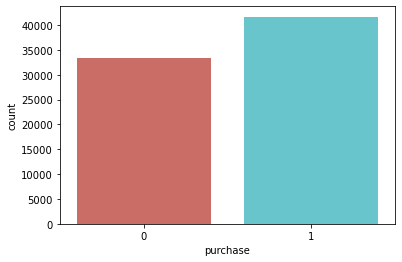

In [24]:
_ = sns.countplot(x = 'purchase', data = X, palette = "hls")
plt.show()

In [25]:
rm_values = ['time', 'account_created_at', 'date_trx', 'date_trx_prev', 'user_id']
_ = X.drop(rm_values, axis = 1, inplace = True)
_ = X_test.drop(rm_values, axis = 1, inplace = True)

<h2>Purchase: Computation</h2>

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LinearRegression

In [27]:
# ignore this; this is to stop sklearn from showing modules are deprecated
from sklearn import preprocessing
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)
    le = preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

Eliminating variables that are correlated

In [28]:
correlated_features = set()
correlation_matrix = X.drop('purchase', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

_ = X.drop(list(correlated_features), axis = 1, inplace = True)
_ = X_test.drop(list(correlated_features), axis = 1, inplace = True)

print(correlated_features)

{'marketing_tier_1', 'marketing_tier_3', 'voucher_min_purchase', 'aov'}


<h3>Computing the model</h3>

In [29]:
y_train = X.purchase
X_train = X.drop('purchase', axis=1)

upsampled_logit = LogisticRegression(solver='liblinear').fit(X_train, y_train)


logit_pred = upsampled_logit.predict(X_test)
logit_pred_proba = upsampled_logit.predict_proba(X_test)

print('Logistic Regression Scores:')
print('Accuracy score: ', accuracy_score(y_test, logit_pred))
print('F1 score: ', f1_score(y_test, logit_pred))
print('Recall score: ', recall_score(y_test, logit_pred))

Logistic Regression Scores:
Accuracy score:  0.7336801476757845
F1 score:  0.8433784262911072
Recall score:  0.7404148536075064


In [30]:
logit_coef = list(upsampled_logit.coef_[0,:])
logit_odds = np.exp(np.abs(logit_coef))

feature_coef = pd.DataFrame({'variable':X_train.columns,
              'coef':logit_coef,
              'odds':logit_odds}).sort_values(['coef'],ascending=False)

feature_coef['odds'] = round(feature_coef['odds'], 2)

feature_coef['probability'] = (feature_coef['odds'] / (1+feature_coef['odds'])) * 100

feature_coef

,variable,coef,odds,probability
5,trx_is_voucher,9.069368,8685.13,99.988487
35,province_17,3.010379,20.30,95.305164
36,province_18,2.863396,17.52,94.600432
2,voucher_max_amount,2.367691,10.67,91.431020
74,referrer_type_6,2.234985,9.35,90.338164
...,...,...,...,...
58,user_type_12,-1.394481,4.03,80.119284
9,sessions,-1.788676,5.98,85.673352
33,province_15,-3.234045,25.38,96.209249
11,num_visit_promo_page,-3.918044,50.30,98.050682


For every one-unit increase in [X variable], the odds that the observation is in purchases are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.

This means that <b>trx_is_voucher</b> & <b>province_18</b> affects successful purchases, while <b>voucher_amount</b> affects unsuccessful purchases.

<h2>Basket Amount: Computation</h2>

In [31]:
# Separate input features and target
y = data_cleaned.basket_amount
X = data_cleaned.drop('basket_amount', axis = 1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 27)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis = 1)

In [32]:
_ = X.drop(list(rm_values), axis = 1, inplace = True)
_ = X_test.drop(list(rm_values), axis = 1, inplace = True)

In [33]:
correlated_features = set()
correlation_matrix = X.drop('basket_amount', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

_ = X.drop(list(correlated_features), axis = 1, inplace = True)
_ = X_test.drop(list(correlated_features), axis = 1, inplace = True)

print(correlated_features)

{'voucher_min_purchase'}


In [34]:
from sklearn import metrics
y_train = X.basket_amount
X_train = X.drop('basket_amount', axis=1)

mlr = LinearRegression().fit(X_train, y_train)

mlr_pred = mlr.predict(X_test)


In [35]:
# calculate linear regression for the model
mlr_coef = list(mlr.coef_)
mlr_odds = np.exp(np.abs(mlr_coef))

feature_coef = pd.DataFrame({'variable':X_train.columns,
              'coef':mlr_coef}).sort_values(['coef'],ascending=False)

feature_coef['coef'] = round(feature_coef['coef'], 5)

feature_coef['mean_increase'] = (feature_coef['coef'] / X['basket_amount'].mean())

feature_coef

,variable,coef,mean_increase
22,aov,0.08388,1106.977121
19,num_trx,0.02591,341.938212
3,voucher_amount,0.00056,7.390405
15,sessions,0.00021,2.771402
18,num_product_types,0.00018,2.375487
23,account_age_days,0.00013,1.715630
17,num_visit_promo_page,0.00008,1.055772
12,account_type,0.00006,0.791829
0,is_new,0.00006,0.791829
26,days_last_trx,0.00002,0.263943


On linear regression, the two variables that affect the increase in overall mean per 1 unit increase is <b>AOV</b> & <b>num_trx</b>. While <b>gmv</b> increase leads to a decrease in basket amount significantly.